# Looking at videos with no detected faces

In [47]:
%reload_ext autoreload
%autoreload 2

In [48]:
#export
from fastai.vision import *
from IPython.display import HTML
import cv2
import pandas as pd
from facenet_pytorch import MTCNN

from kgl_deepfake.nb_00 import *
from kgl_deepfake.nb_01a import *
from kgl_deepfake.nb_01b import *

### Data

In [4]:
SOURCE = Path('../data/train_sample_videos/')

In [5]:
annots = pd.read_csv('annots_noface.csv')

In [6]:
annots.head()

,fname,label,split,original
0,adhsbajydo.mp4,FAKE,train,fysyrqfguw.mp4
1,agrmhtjdlk.mp4,REAL,train,NaN
2,andaxzscny.mp4,FAKE,train,fysyrqfguw.mp4
3,aorjvbyxhw.mp4,FAKE,train,bulkxhhknf.mp4
4,atvmxvwyns.mp4,REAL,train,NaN


In [6]:
fnames = [SOURCE/o for o in annots.fname]
labels = [f'{o.fname} {o.label}' for i, o in annots.iterrows()]

In [7]:
HTML(html_vids(fnames, titles=labels))

### Darkish videos

Many of these videos have poor lighting.  Let's consider these in this section.

In [52]:
fn = 'atvmxvwyns.mp4'

In [53]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
detector = MTCNN(device=device, post_process=False)

#### Using `get_first_face`

If we use a half-sized frame (`resize = .5` by default in `get_first_face`), then a face is detected in frame 236.

In [55]:
face = get_first_face(detector, SOURCE/fn)

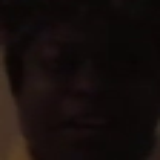

In [58]:
Image(face[1].type(torch.uint8))

In [59]:
face[0]

236

If we use an original-sized frame, a face is detected in frame 194, earlier than when a half-sized frame is used.

In [61]:
face = get_first_face(detector, SOURCE/fn, resize=None)

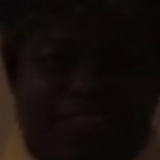

In [63]:
Image(face[1].type(torch.uint8))

In [64]:
face[0]

194

#### Adjusting brightness of first frame

Since the lighting is very dark in this video.  Let's see what happens if we increase the brightness in frame 0, in which no face is detected.

In [202]:
vcap = cv2.VideoCapture(str(SOURCE/fn))

In [203]:
success, frame = vcap.read()

In [204]:
success

True

In [205]:
vcap.release()

In [206]:
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
#frame = PIL.Image.fromarray(frame)

In [207]:
pilimg = PIL.Image.fromarray(frame)
img = tensor(frame).permute(2, 0, 1)

Scale up all values increases the brightness of the image.  (Don't know if there is a better way to increase brightness.)

In [208]:
img_brighter = (2 * img.float()).clamp_max(255).clamp_min(0).type(torch.uint8)

In [209]:
pilimg_brighter = PIL.Image.fromarray(img_brighter.permute(1, 2, 0).numpy())

tensor([44.7277, 32.8818, 23.9042])

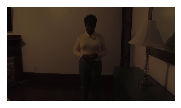

In [210]:
Image(img).show(); img.float().mean(dim=[1, 2])

tensor([89.4554, 65.7637, 47.8085])

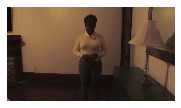

In [211]:
Image(img_brighter).show(); img_brighter.float().mean(dim=[1, 2])

In [214]:
face = detector(pilimg)

In [215]:
face is None

True

In [216]:
face_brighter = detector(pilimg_brighter)

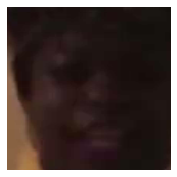

In [219]:
Image(face_brighter.type(torch.uint8)).show()

By increasing the brightness, a face from the first frame of the following videos is detected:

* esyhwdfnxs.mp4 2x  
* eoewqcpbgt.mp4 2x
* atvmxvwyns.mp4 2x

'2x' indicates that the image array was multiplied by 2.  Multiplying by 1.5 didn't work, at least not for the first video listed here.

### Video with two people

In [8]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
detector = MTCNN(device=device, post_process=False)

In [9]:
fn = 'agrmhtjdlk.mp4'

Let's first reproduce the problem: that no face is detected using `DetectionPipeline`.

#### Using `get_first_face`

There was a bug with a previous version of this function.  After this was fixed, it now detects face. 

This will only return the face of the woman, because it's the first face to appear in the video.

In [10]:
face = get_first_face(detector, SOURCE/fn)

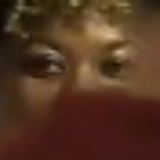

In [11]:
Image(face[1].type(torch.uint8))

#### Using `DetectionPipeline`

In [13]:
detectpipe = DetectionPipeline(detector, resize=.5)

In [14]:
faces = detectpipe(str(SOURCE/fn))

In this image below, the man's back is to the viewer, he's partially blocking the woman's face.  In this frame, the woman's face is the only face.

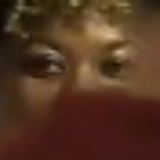

In [23]:
Image(faces[5].type(torch.uint8))

In the video, the man turns around and reveals his face, making his the other face in the frame below.  In this case, the detector returns the man's face instead of the woman's.

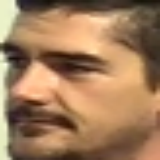

In [16]:
Image(faces[178].type(torch.uint8))

#### Using cv2 straight up 

In [68]:
vcap = cv2.VideoCapture(str(SOURCE/fn))

In [69]:
vlen = int(vcap.get(cv2.CAP_PROP_FRAME_COUNT))

Let's look at a frame with 2 faces

In [70]:
idxs = [203]

In [71]:
frames = []
for i in range(vlen):
    success, frame = vcap.read()
    if i in idxs:
        if success: frames.append(frame)
        else: frames.append(None)
    if i == idxs[-1]: break

In [72]:
vcap.release()

In [73]:
len(frames)

1

In [74]:
frames = [cv2.cvtColor(o, cv2.COLOR_BGR2RGB) for o in frames]

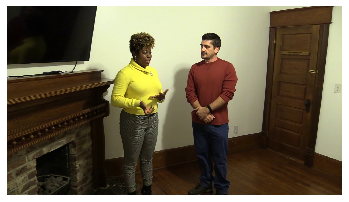

In [75]:
plt.imshow(frames[0]); plt.axis('off');

In [76]:
img = frames[0]
pilimg = PIL.Image.fromarray(img)

Resize the image by 0.5, the woman's face is detected.

In [77]:
sz_smll = tuple(int(.5 * o) for o in pilimg.size)
sz_smll

(960, 540)

In [78]:
face = detector(pilimg.resize(sz_smll))

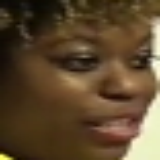

In [79]:
Image(face.type(torch.uint8))

Using frame with original size, the man's face is detected.

In [80]:
face = detector(pilimg)

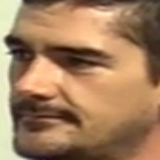

In [81]:
Image(face.type(torch.uint8))

#### Mini-summary
It's hard to tell which face the detector will pick out of the two.  In some frames, it picks out the woman's, in some other it picks out the man's.

### The very-blurry-face one

In [7]:
fn = 'aorjvbyxhw.mp4'

In [12]:
HTML(html_vid(SOURCE/fn))

In [49]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
detector = MTCNN(device=device, post_process=False)

`get_first_face` now returns a face from the second frame, which means the bug before prevented a face to be detected in this video.

In [50]:
face = get_first_face(detector, SOURCE/fn)

300
0
1


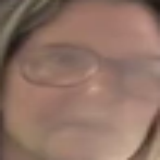

In [51]:
Image(face[1].type(torch.uint8))

### Check all those videos in which no face was detected previously

In [67]:
face_fns = []

for i in progress_bar(range(annots.shape[0])):
    face = get_first_face(detector, SOURCE/annots.fname[i])
    face_fns.append(face)
    

In [73]:
fnames_noface = [fn for (iframe, face), fn in zip(face_fns, annots.fname) if iframe is None]


In [76]:
HTML(html_vids([SOURCE/fn for fn in fnames_noface], titles=fnames_noface))

Watching these, it appears that in most of them there is a brief moment in which the view is out of focus so everything is blurry.

### Look at full-sized frames (`resize=None`) for 4 videos which still return no face

In [77]:
fnames_noface

['andaxzscny.mp4', 'avvdgsennp.mp4', 'cwqlvzefpg.mp4', 'esyhwdfnxs.mp4']

In [102]:
fn = fnames_noface[0]
fn

'andaxzscny.mp4'

In [103]:
%%time
face = get_first_face(detector, SOURCE/fn, resize=None)

CPU times: user 1.43 s, sys: 231 ms, total: 1.66 s
Wall time: 1.27 s


1

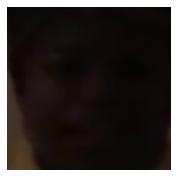

In [104]:
Image(face[1].type(torch.uint8)).show(); face[0]

In [105]:
fn = fnames_noface[1]
fn

'avvdgsennp.mp4'

In [106]:
%%time
face = get_first_face(detector, SOURCE/fn, resize=None)

CPU times: user 17.2 s, sys: 2.63 s, total: 19.8 s
Wall time: 15.2 s


24

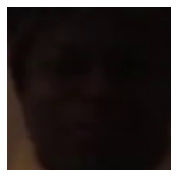

In [107]:
Image(face[1].type(torch.uint8)).show(); face[0]

In [108]:
fn = fnames_noface[2]
fn

'cwqlvzefpg.mp4'

In [109]:
%%time
face = get_first_face(detector, SOURCE/fn, resize=None)

CPU times: user 9.64 s, sys: 1.57 s, total: 11.2 s
Wall time: 8.81 s


13

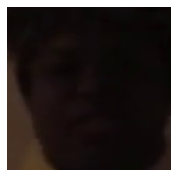

In [110]:
Image(face[1].type(torch.uint8)).show(); face[0]

In [111]:
fn = fnames_noface[3]
fn

'esyhwdfnxs.mp4'

In [112]:
%%time
face = get_first_face(detector, SOURCE/fn, resize=None)

CPU times: user 4.19 s, sys: 647 ms, total: 4.83 s
Wall time: 3.68 s


5

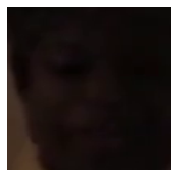

In [113]:
Image(face[1].type(torch.uint8)).show(); face[0]

#### Mini-summary
It looks like using full-sized frames, faces are detected for these last 4 videos.  If we use full-sized frames, then we are guaranteed to get a face for every video in *train_sample_videos*.  If we use half-sized frames, then, as things stand, these 4 videos will have no face detected.

### Total/mean brightness

Take these 2 relatively bright videos.

In [138]:
fns_bright = ['aorjvbyxhw.mp4', 'agrmhtjdlk.mp4']

In [139]:
HTML(html_vids([SOURCE/o for o in fns_bright], fns_bright))

aorjvbyxhw.mp4,agrmhtjdlk.mp4


In [161]:
def get_first_frame(fn):
    assert Path(fn).exists()
    capture = cv2.VideoCapture(str(fn))
    vlen = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))
    iframe, frame1 = None, None
    for i in range(vlen):
        success, frame = capture.read()
        if success:
            iframe, frame1 = i, frame
            break
    return iframe, frame1

Get the first frame of these 2 bright videos and of those dark videos above.

In [162]:
dark = np.stack([get_first_frame(SOURCE/fn)[1] for fn in fnames_noface])

In [163]:
bright = np.stack([get_first_frame(SOURCE/fn)[1] for fn in fns_bright])

Calculate the mean of the bright frames and of the dark frames.  It's seen that dark frames' mean is somewhat smaller than the bright frames'.

In [164]:
dark.mean(), bright.mean()

(33.77181455761317, 109.54409730259773)

Let's try increasing the brightness of a video if it's too dark to begin with, and see if faces can be detected in half-sized frames afterwards:

1. Take the video's first frame.
2. Calculate the frame's mean value.
3. If mean value is less than 35, say, then multiply all frames of the video by 2.
4. Do face detection on these frames.

Add option to scale frame in `get_first_face`.

In [182]:
def get_first_face(detector, fn, resize=.5, bright=None):
    '''
    Returns the first detected face from a video
    '''
    assert Path(fn).exists()
    v_cap = cv2.VideoCapture(str(fn))
    v_len = int(v_cap.get(cv2.CAP_PROP_FRAME_COUNT))
    iframe, face = None, None
    for i in range(v_len):
        _ = v_cap.grab()
        success, frame = v_cap.retrieve()
        if not success: continue
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        if bright is not None: frame *= int(bright)
        frame = PIL.Image.fromarray(frame)
        if resize is not None: frame = frame.resize([int(d * resize) for d in frame.size])
        face = detector(frame)
        if face is not None: 
            iframe = i
            break
    v_cap.release()
    return iframe, face

In [160]:
fnames_noface

['andaxzscny.mp4', 'avvdgsennp.mp4', 'cwqlvzefpg.mp4', 'esyhwdfnxs.mp4']

In [211]:
fn = fnames_noface[3]

In [212]:
mean_frame = get_first_frame(SOURCE/fn)[1].mean()

In [213]:
mean_frame

33.79118730709877

In [198]:
face = get_first_face(detector, SOURCE/fn)

In [199]:
face

(None, None)

Increasing brightness by 2 returns a face in the first frame.

In [214]:
face = get_first_face(detector, SOURCE/fn, bright=2.)

0

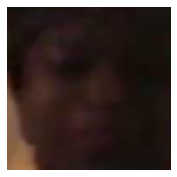

In [215]:
Image(face[1].type(torch.uint8)).show(); face[0]

With a 4x increase in brightness, the colours look funny and there is some sort of pixelation effect. Not sure if this is a good idea.

In [216]:
face = get_first_face(detector, SOURCE/fn, bright=4.)

0

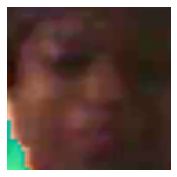

In [217]:
Image(face[1].type(torch.uint8)).show(); face[0]

**So yes, increasing the brightness seems to allow the face detector to find a face in half-sized frames.**

### Modify `VideoFaceList` to automatically adjust brightness if it's too low

In [218]:
class VideoFaceList(ImageList):
    def __init__(self, *args, detector=None, resize=.5, device=None, **kwargs):
        if device is None: device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
        if detector is None: detector = MTCNN(device=device, post_process=False)
        self.detector, self.resize = detector, resize
        super().__init__(*args, **kwargs)
    
    def get_face(self, fn:Path):
        f = get_first_frame(fn)[1]
        bright = 2. if f.mean() < 35 else None
        iframe, face = get_first_face(self.detector, fn, self.resize, bright=bright)
        if iframe is None or face is None: raise Exception(f'No faces detected in {fn}')
        return iframe, face
    
    def open(self, fn:Path):
        iframe, face = self.get_face(fn)
        return Image(face / 255)

Let's see if we can construct a `VideoFaceList` for the entire `train_sample_videos`, without having to filter out certain videos.

In [219]:
SOURCE = Path('../data/train_sample_videos')

In [227]:
f = get_files(SOURCE, extensions=['.json'])
annots = pd.read_json(f[0]).T
annots.reset_index(inplace=True)
annots.rename({'index':'fname'}, axis=1, inplace=True)
annots.head()

,fname,label,split,original
0,aagfhgtpmv.mp4,FAKE,train,vudstovrck.mp4
1,aapnvogymq.mp4,FAKE,train,jdubbvfswz.mp4
2,abarnvbtwb.mp4,REAL,train,None
3,abofeumbvv.mp4,FAKE,train,atvmxvwyns.mp4
4,abqwwspghj.mp4,FAKE,train,qzimuostzz.mp4


In [228]:
%%time
src = (VideoFaceList
       .from_df(annots, path=SOURCE, cols='fname', detector=detector)
       .split_by_rand_pct())

CPU times: user 25.7 ms, sys: 10.8 ms, total: 36.5 ms
Wall time: 58.6 ms


In [232]:
bs, sz = 23, 128

In [233]:
%%time
data = (src.label_from_df('label').transform(get_transforms(), size=sz)
        .databunch(bs=bs, device=device, num_workers=0).normalize(imagenet_stats))

CPU times: user 14.3 s, sys: 2.12 s, total: 16.5 s
Wall time: 9.65 s


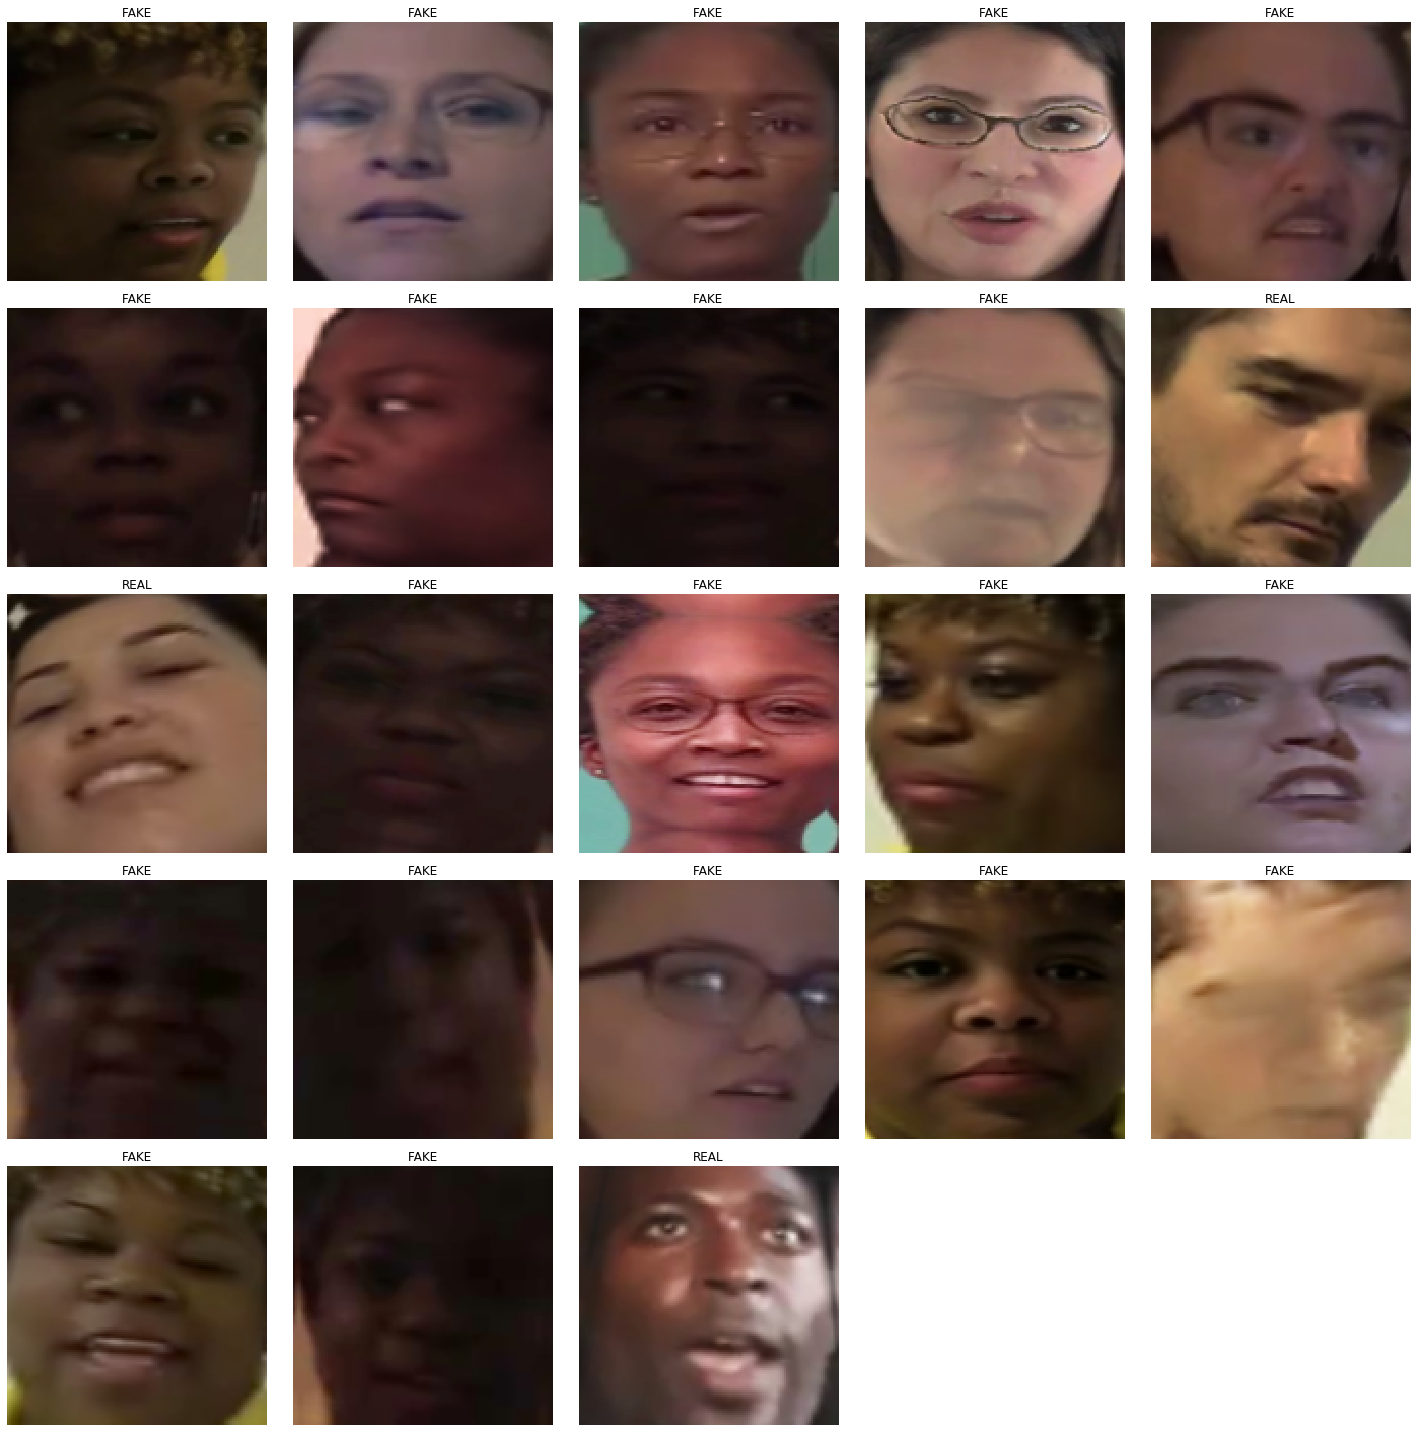

In [235]:
data.show_batch()

In [236]:
%%time
xb, yb = next(iter(data.train_dl))

CPU times: user 13.4 s, sys: 1.89 s, total: 15.3 s
Wall time: 8.98 s


In [239]:
xb.shape, xb.mean(), xb.std()

(torch.Size([23, 3, 128, 128]), tensor(-0.5207), tensor(0.7612))

In [240]:
%%time
xb, yb = next(iter(data.valid_dl))

CPU times: user 12.6 s, sys: 1.89 s, total: 14.5 s
Wall time: 8.54 s


In [241]:
xb.shape, xb.mean(), xb.std()

(torch.Size([23, 3, 128, 128]), tensor(-0.5772), tensor(0.7698))

# - fin